# Lab 7 - Recurrent Neural Networks
##### By. Liam Lowsley-Williams & Fernando Vázquez

## Business Understanding

Dataset - https://www.kaggle.com/shitalkat/amazonearphonesreviews

### Introduction

For this lab, we decided to choose the Amazon Earphones Reviews dataset from Kaggle. This dataset consists of 14,337 reviews of 10 different bluetooth earphones. The Reviews contain a title, body, and ranking. The ranking is evaluated as being 1 through 5, 1 being poor and 5 being excellent. The earphones are the latest devices released in the market as of mid-2019. We plan to use this dataset to provide sentiment analysis for product reviews which then could be expanded to a targeted market area. Even further expansion could be targeted sentiment analysis on any category of consumer products.

### Motivations

Our motivations for this business case mentioned above stem from primarily from the topic of sentiment analysis. Sentiment analysis is one of the topics in machine learning that can be classified fairly accurately given good data to train on. Thus, given we are classifying the review score of a given review via the text, sentiment obviously plays a role here. We hope to be able to classify the sentiment of a given review in a targeted fashion (as we are dealing with technology-related products) such that we can make a fairly accurate prediction on the sentiment. 

More specifically as a business case, we hope to be able to use this classifier to analyze text based reviews on products and make an accurate prediction of the sentiment/rank of that review. The reason we are interested in this is because with the age of personal blogs and websites that performs reviews on products, not all come with a ranking score, or, the ranking score is not standardized. Since our analyzer is purely based on text, we hope to train it to recognize positive, neutral, and negative reviews and classify them as such accurately. This process could then be automated and coupled with a web crawler to provide a general market analysis on the success of a given product. This would give companies insight on their products more quickly and efficiently than a marketing analyst could ever do and could result in saved time and money. 

In addition, we also make the case that this type of analyzer could be expanded to any other product category as well. In particular, clothing or consumer appliances could be areas of interest to use such an analyzer. This would obviously need custom tailored training given the product category/type.


### Objectives

Our objective for this use case is to have our performance metric, accuracy (more on this later), be at least greater than <b>85%</b> to be useful. Ideally, we would want as high an accuracy as possible, however, with text based data, we expect to see a bit lower accuracy as it is one of the harder areas to make a prediction. This is due to the fact that the english language can take on a vast number of different combinations that eventually equate to the same meaning. Thus, an accuracy of above <b>85%</b> is pretty good, and accuracy above <b>90%</b> is good, and and accuracy above <b>95%</b> is state of the art. 

### Evaluation

Our business case calls for being able to accurately classify the sentiment of Amazon Reviews. With the rise of E commerce, companies such as Amazon and Walmart want to be able to determine how well a product is doing and a way of doing so is with product reviews. With thousands of products these companies are not able to go through all of the product reviews by assigning employees to complete the task, therefore it is important for these companies to be able determine the sentiment automatically. Given these scenarios we have decided to use accuracy as our metric to evaluate the performance of the model because we want to be able to correctly distinguish between the sentiment of any type of review. The reasoning for this is because incorrect classification in language processing will lead to more problems down the road for not only the employees managing the sentiment analyzer but could also lead to potential monetary losses to the companies involved. Accuracy is determined by taking the number of correct predictions and dividing it by the total amount of predictions. We also chose to use accuracy since our data has the same number of instances for each class therefore bias isn't given to any one class. We were able to make this assumption when we combined ratings that were marked as 1 or 2 and 4 or 5.

$$Accuracy=\frac{Correct Predictions}{Total Predictions}$$

## Init

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.0.0
Default GPU Device: /device:GPU:0


In [2]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

from sklearn import metrics as mt
from sklearn.manifold import TSNE
import random
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

# graph visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.__version__

Using TensorFlow backend.


'2.3.1'

## Data Preparation

In terms of data preparation for this dataset, we chose to change up a few things. Firstly, we combine the review title "ReviewTitle" with the body "ReviewBody" to make one centralized body of text per review for analysis. We then take the data and combine some of the 5 rankings to have ultimately 3 rankings, positive, neutral, and negative. From the original data reviews of rank 1 and 2 will be negative, reviews of rank 3 will be neutral, and reviews of rank 4 and 5 will be positive.

We then tokenize the text data and pad it into sequences and one hot encode the target which contains our 3 classes. For tokenization we chose a max article length of the largest review as this is a small dataset and since the largest review was also only around ~850 words, we decided to keep all the information we could possibly get. The Keras tokenizer will also remove all punctuation, special characters, tabs and newlines, but leave single quotes ('). 

We had previously tried classifying by the ranking (1-5) however we saw really low accuracies and decided that grouping the ranks into positive, neutral, and negative would help improve the metric. In the end we saw a 20% increase in the accuracy of our network when shrinking the number of classes to predict from 5 to 3.


In [3]:
data = pd.read_csv("reviews.csv")
data

,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255
...,...,...,...,...
14332,Good\n,Good\n,4,JBL T110BT
14333,Amazing Product\n,An amazing product but a bit costly.\n,5,JBL T110BT
14334,Not bad\n,Sound\n,1,JBL T110BT
14335,a good product\n,the sound is good battery life is good but the...,5,JBL T110BT


In [4]:
data_title = data["ReviewTitle"]
data_body = data["ReviewBody"]

data_new = pd.DataFrame()
data_new["rank"] = data["ReviewStar"]

In [5]:
data_new["review"] = data["ReviewTitle"].map(str) + " " + data["ReviewBody"]
data_new

,rank,review
0,3,Honest review of an edm music lover\n No doubt...
1,1,Unreliable earphones with high cost\n This ea...
2,4,"Really good and durable.\n i bought itfor 999,..."
3,1,stopped working in just 14 days\n Its sound qu...
4,5,Just Awesome Wireless Headphone under 1000...😉...
...,...,...
14332,4,Good\n Good\n
14333,5,Amazing Product\n An amazing product but a bit...
14334,1,Not bad\n Sound\n
14335,5,a good product\n the sound is good battery lif...


In [6]:
data_final_1 = data_new.loc[data_new['rank'].isin(['1','2'])].copy()
data_final_1["rank"] = '0'
data_final_1

,rank,review
1,0,Unreliable earphones with high cost\n This ea...
3,0,stopped working in just 14 days\n Its sound qu...
5,0,"Charging port not working\n After 11 days, the..."
9,0,Very very bad Durabity\n The product durabilit...
11,0,Disappointed\n What on earth is the use of buy...
...,...,...
14329,0,It's from jbl or road side product!? Magic ...
14330,0,Ok\n Very bad\n
14331,0,Bad performance\n Very bad sound call quality ...
14334,0,Not bad\n Sound\n


In [7]:
data_final_2 = data_new.loc[data_new['rank'].isin(['3'])].copy()
data_final_2["rank"] = '1'
data_final_2

,rank,review
0,1,Honest review of an edm music lover\n No doubt...
7,1,Great sound with worst mic.\n After one month ...
15,1,Good Earphones with good sound quality and bui...
17,1,Good product with decent pros\n The product is...
19,1,Overall good but not that worth\n he only prob...
...,...,...
14257,1,Three Stars\n Super\n
14285,1,Good sound\n Good\n
14291,1,Never buy it\n Only in 1 month battery doesn't...
14294,1,Normal\n Average\n


In [8]:
data_final_3 = data_new.loc[data_new['rank'].isin(['4','5'])].copy()
data_final_3["rank"] = '2'
data_final_3

,rank,review
2,2,"Really good and durable.\n i bought itfor 999,..."
4,2,Just Awesome Wireless Headphone under 1000...😉...
6,2,Loved the color and sound !!\n Sound-4.5/5Buil...
8,2,Battery life is good enough to keep going all ...
10,2,Running has become comfortable now\n The sound...
...,...,...
14327,2,Excellent..Just go for it..\n Have been using ...
14328,2,Quallity maintain is good\n Very good product ...
14332,2,Good\n Good\n
14333,2,Amazing Product\n An amazing product but a bit...


In [9]:
data_final = pd.concat([data_final_1, data_final_2, data_final_3], axis=0)
data_final

,rank,review
1,0,Unreliable earphones with high cost\n This ea...
3,0,stopped working in just 14 days\n Its sound qu...
5,0,"Charging port not working\n After 11 days, the..."
9,0,Very very bad Durabity\n The product durabilit...
11,0,Disappointed\n What on earth is the use of buy...
...,...,...
14327,2,Excellent..Just go for it..\n Have been using ...
14328,2,Quallity maintain is good\n Very good product ...
14332,2,Good\n Good\n
14333,2,Amazing Product\n An amazing product but a bit...


In [10]:
X_data = data_final["review"]
X_data

1        Unreliable earphones with high cost\n This  ea...
3        stopped working in just 14 days\n Its sound qu...
5        Charging port not working\n After 11 days, the...
9        Very very bad Durabity\n The product durabilit...
11       Disappointed\n What on earth is the use of buy...
                               ...                        
14327    Excellent..Just go for it..\n Have been using ...
14328    Quallity maintain is good\n Very good product ...
14332                                        Good\n Good\n
14333    Amazing Product\n An amazing product but a bit...
14335    a good product\n the sound is good battery lif...
Name: review, Length: 14337, dtype: object

In [11]:
y_data = data_final["rank"]
y_data

1        0
3        0
5        0
9        0
11       0
        ..
14327    2
14328    2
14332    2
14333    2
14335    2
Name: rank, Length: 14337, dtype: object

In [12]:
%%time
NUM_TOP_WORDS = None
MAX_ART_LEN = X_data.map(lambda x: len(x.split())).max() # maximum and minimum number of words
NUM_CLASSES = 3

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y_data)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 12156 unique tokens. Distilled to 12156 top words.
Shape of data tensor: (14337, 868)
Shape of label tensor: (14337, 3)
12156
Wall time: 625 ms


In [13]:
np.sum(y_ohe, axis=0)

array([3432., 1503., 9402.], dtype=float32)

## Evaluation & Data Splitting

In [14]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2,
                                                              stratify=y_data, 
                                                              random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(np.sum(y_train,axis=0))
print(np.sum(y_test,axis=0))

(11469, 868) (11469, 3)
(2868, 868) (2868, 3)
[2746. 1202. 7521.]
[ 686.  301. 1881.]


We chose to split our data set via an 80/20 stratified split. We figured this would be the best way to split the data and that an 80/20 was acceptable given we have around ~14k instances.

### Model 1

For our first architecture we chose to use a Simple RNN with an embedding layer that was made from scratch. Our input size was the max article length, as stated above, to ensure we used all of the data during training since the size of the dataset is fairly small. Our output dimensionality for the embedding layer was 150 and our output dimensionality for the SimpleRNN layer was 100. We found using a lower dimension output space on the SimpleRNN typically provided better results. Of course, the last layer is simply the activation function.

In [15]:
max_review_length = MAX_ART_LEN
EMBED_SIZE = 150
embedding_layer = Embedding(X_train.shape[1],
                            EMBED_SIZE,
                            input_length=MAX_ART_LEN)

rnn1 = Sequential()
rnn1.add(embedding_layer)
rnn1.add(SimpleRNN(100,dropout=0.2, recurrent_dropout=0.2))
rnn1.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 868, 150)          130200    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               25100     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 155,603
Trainable params: 155,603
Non-trainable params: 0
_________________________________________________________________
None


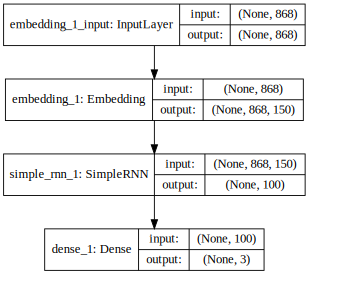

In [16]:
SVG(model_to_dot(rnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [17]:
history1 = rnn1.fit(X_train, y_train, 
        epochs=15, 
        batch_size=64, 
        validation_data=(X_test, y_test), 
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
       )

C:\Users\liaml\Anaconda3\envs\gputest\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11469 samples, validate on 2868 samples
Epoch 1/15
11469/11469 [==============================] - 119s 10ms/step - loss: 0.9268 - accuracy: 0.5931 - val_loss: 0.8187 - val_accuracy: 0.6562
Epoch 2/15
11469/11469 [==============================] - 118s 10ms/step - loss: 0.7999 - accuracy: 0.6694 - val_loss: 0.7194 - val_accuracy: 0.7099
Epoch 3/15
11469/11469 [==============================] - 119s 10ms/step - loss: 0.7222 - accuracy: 0.7042 - val_loss: 0.6578 - val_accuracy: 0.7517
Epoch 4/15
11469/11469 [==============================] - 118s 10ms/step - loss: 0.6802 - accuracy: 0.7406 - val_loss: 0.6175 - val_accuracy: 0.7709
Epoch 5/15
11469/11469 [==============================] - 119s 10ms/step - loss: 0.6535 - accuracy: 0.7541 - val_loss: 0.6207 - val_accuracy: 0.7744
Epoch 6/15
11469/11469 [==============================] - 118s 10ms/step - loss: 0.6259 - accuracy: 0.7635 - val_loss: 0.6271 - val_accuracy: 0.7632


In [20]:
rnn1.save_weights('model_1_weights.h5')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'epochs')

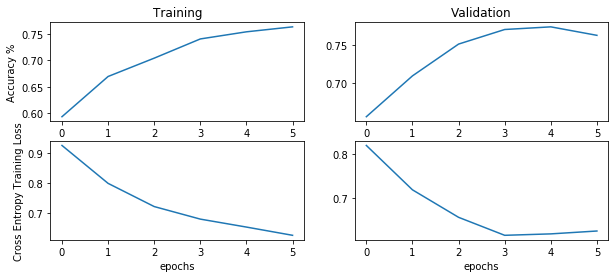

In [21]:
print(history1.history.keys())
plt.figure(figsize=(10,4))

plt.subplot(2,2,1)
plt.plot(history1.history['accuracy'])
plt.ylabel('Accuracy %')
plt.title('Training')

plt.subplot(2,2,2)
plt.plot(history1.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history1.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history1.history['val_loss'])
plt.xlabel('epochs')

In our first model, we were able to obtain a top accuracy of 77.44% in the 5th epoch. This is ok as a start but clearly not good enough for our automated system. In the next architecture we will look into changing to a LSTM layer instead of the SimpleRNN.

### Model 2

For our second architecture, we chose to use a LSTM with a pretrained embedding layer taken from Stanford’s glove embeddings. We used their 6 billion token and 200-dimensional space embedding and thus had an output dimensionality of 200. For the LSTM layer, we chose to make the dimensionality output of the layer 100 which seemed to work quite well. In addition, just like above, the last layer is simply the activation function.

In [22]:
%%time

EMBED_SIZE = 200
embeddings_index = {}

f = open('./glove/glove.6B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(12157, 200)
Wall time: 20.5 s


In [23]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [24]:
rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 868, 200)          2431400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 2,552,103
Trainable params: 120,703
Non-trainable params: 2,431,400
_________________________________________________________________
None


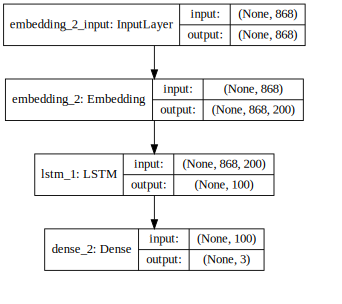

In [25]:
SVG(model_to_dot(rnn2, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [26]:
history2 = rnn2.fit(X_train, 
        y_train, 
        epochs=15, 
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
       )

Train on 11469 samples, validate on 2868 samples
Epoch 1/15
11469/11469 [==============================] - 138s 12ms/step - loss: 0.6811 - accuracy: 0.7342 - val_loss: 0.6098 - val_accuracy: 0.7803
Epoch 2/15
11469/11469 [==============================] - 137s 12ms/step - loss: 0.5426 - accuracy: 0.7988 - val_loss: 0.4893 - val_accuracy: 0.8204
Epoch 3/15
11469/11469 [==============================] - 136s 12ms/step - loss: 0.4999 - accuracy: 0.8110 - val_loss: 0.4775 - val_accuracy: 0.8222
Epoch 4/15
11469/11469 [==============================] - 137s 12ms/step - loss: 0.5409 - accuracy: 0.8007 - val_loss: 0.4667 - val_accuracy: 0.8218
Epoch 5/15
11469/11469 [==============================] - 138s 12ms/step - loss: 0.4481 - accuracy: 0.8301 - val_loss: 0.4730 - val_accuracy: 0.8225
Epoch 6/15
11469/11469 [==============================] - 137s 12ms/step - loss: 0.4309 - accuracy: 0.8339 - val_loss: 0.4768 - val_accuracy: 0.8058


In [27]:
rnn2.save_weights('model_2_weights.h5')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'epochs')

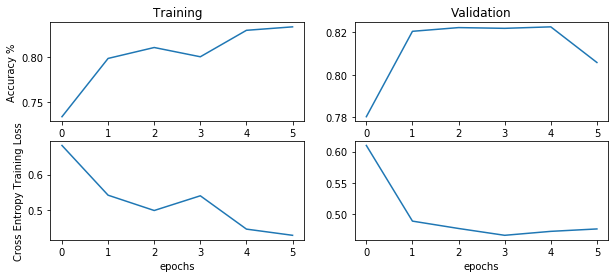

In [28]:
print(history2.history.keys())
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history2.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history2.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history2.history['val_loss'])
plt.xlabel('epochs')

Here we can see that we got a top accuracy of around 82.25% on Epoch 5 again. This is a better than our first model for sure but, ideally, we would really like to see an accuracy in the 90s for our purpose. We will now use this model and add a second chain to it below.

### RNN With Second Chain

For our 3rd-ish architecture we simply took the model that performed the best (in this case the second) and added another LSTM chain to the rnn right after the 1st LSTM layer. That was really the only change we saw here.

In [29]:
embedding_layer3 = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [30]:
rnn3 = Sequential()
rnn3.add(embedding_layer3)
rnn3.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn3.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn3.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn3.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 868, 200)          2431400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 868, 100)          120400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 2,632,503
Trainable params: 201,103
Non-trainable params: 2,431,400
_________________________________________________________________
None


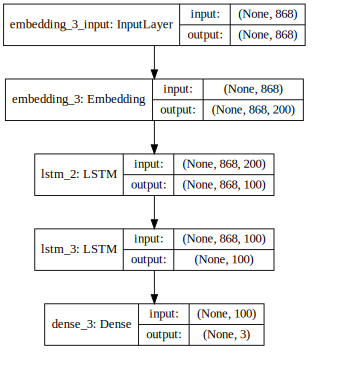

In [31]:
SVG(model_to_dot(rnn3, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [32]:
history3 = rnn3.fit(X_train, 
        y_train, 
        epochs=15, 
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
       )

Train on 11469 samples, validate on 2868 samples
Epoch 1/15
11469/11469 [==============================] - 288s 25ms/step - loss: 0.6658 - accuracy: 0.7413 - val_loss: 0.5772 - val_accuracy: 0.7838
Epoch 2/15
11469/11469 [==============================] - 288s 25ms/step - loss: 0.5352 - accuracy: 0.7998 - val_loss: 0.5065 - val_accuracy: 0.8093
Epoch 3/15
11469/11469 [==============================] - 287s 25ms/step - loss: 0.5051 - accuracy: 0.8075 - val_loss: 0.4609 - val_accuracy: 0.8232
Epoch 4/15
11469/11469 [==============================] - 286s 25ms/step - loss: 0.4735 - accuracy: 0.8215 - val_loss: 0.4488 - val_accuracy: 0.8319
Epoch 5/15
11469/11469 [==============================] - 286s 25ms/step - loss: 0.4518 - accuracy: 0.8317 - val_loss: 0.4487 - val_accuracy: 0.8340
Epoch 6/15
11469/11469 [==============================] - 286s 25ms/step - loss: 0.5093 - accuracy: 0.8138 - val_loss: 0.4187 - val_accuracy: 0.8403
Epoch 7/15
11469/11469 [==============================] -

In [33]:
rnn3.save_weights('model_3_weights.h5')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'epochs')

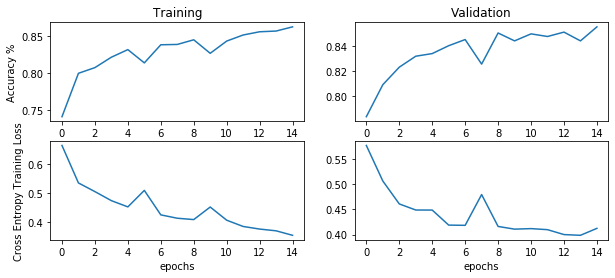

In [34]:
print(history3.history.keys())
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history3.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history3.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history3.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history3.history['val_loss'])
plt.xlabel('epochs')

In our last architecture with the second chain, we saw a top accuracy of 85.53%. This was our best accuracy yet and can be deemed useful. From the graphs above we can see that there was some turbulance midway through but ultimately the model recovered. This was also the only model that ran for the full 15 epochs, so we could possibly run it for longer and get a much better accuracy. Unfortunately due to time constraints, we were unable to run the model for more epochs.

### Comparison of all 3 models

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Text(0.5, 0, 'epochs')

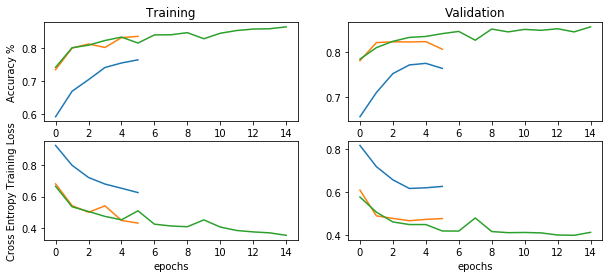

In [35]:
print(history3.history.keys())
plt.figure(figsize=(10,4))

plt.subplot(2,2,1)
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.ylabel('Accuracy %')
plt.title('Training')

plt.subplot(2,2,2)
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.ylabel('Cross Entropy Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('epochs')

As seen above, the first two architectures only ran for 5 epochs where the last architecture ran for the full 15. We can also see that our best architecture was the 3rd one and that we would expand on that one for our business case.

## Exceptional Credit

In [40]:
#We used this Stack Overflow post to get access to all of the word embeddings
#https://stackoverflow.com/questions/51235118/how-to-get-word-vectors-from-keras-embedding-layer/51235358
embeddings = rnn2.layers[0].get_weights()[0]
print(len(embeddings))
words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}
subset_dict={}
count=0
for x in range(len(words_embeddings)):
    key= random.choice(list(words_embeddings.keys())) 
    subset_dict[key]=words_embeddings[key];
    if x==100:
        break
print("Len of new Dict",len(subset_dict))
print(subset_dict)

12157
Len of new Dict 101
{'companions': array([ 0.29618  ,  0.024251 , -0.028018 , -0.35809  , -0.29388  ,
       -0.66868  , -0.19448  , -0.10353  , -0.52618  ,  0.28209  ,
       -0.010908 , -0.13798  , -0.13791  , -0.062209 , -0.63125  ,
        0.017421 ,  0.1736   ,  0.23212  , -0.19143  , -0.075104 ,
        0.0043654,  0.90317  ,  0.93858  , -0.309    ,  0.12654  ,
       -0.41017  ,  0.17502  , -0.39496  ,  0.25603  , -0.22427  ,
       -0.075981 ,  0.73812  ,  0.68049  , -0.68836  ,  0.20103  ,
       -0.021323 , -0.38076  ,  0.23939  , -0.13378  , -0.073285 ,
       -0.10526  ,  0.22723  , -0.0060288,  0.71196  , -0.19266  ,
        0.14475  , -0.036564 ,  0.23011  ,  0.4659   ,  0.29396  ,
       -0.60381  ,  0.041953 ,  0.091599 ,  0.29085  ,  0.45509  ,
        0.13569  ,  0.26095  , -0.48183  ,  0.3304   , -0.2372   ,
       -0.1467   , -0.13305  , -0.25981  , -0.043573 , -0.29881  ,
       -0.11665  ,  0.4225   ,  0.37169  , -0.45298  , -0.02542  ,
        0.33157  , -0

C:\Users\liaml\Anaconda3\envs\gputest\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\liaml\Anaconda3\envs\gputest\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56911 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\liaml\Anaconda3\envs\gputest\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\liaml\Anaconda3\envs\gputest\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 56911 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\liaml\Anaconda3\envs\gputest\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\liaml\Anaconda3\envs\gputest\lib\site-packages\matplotl

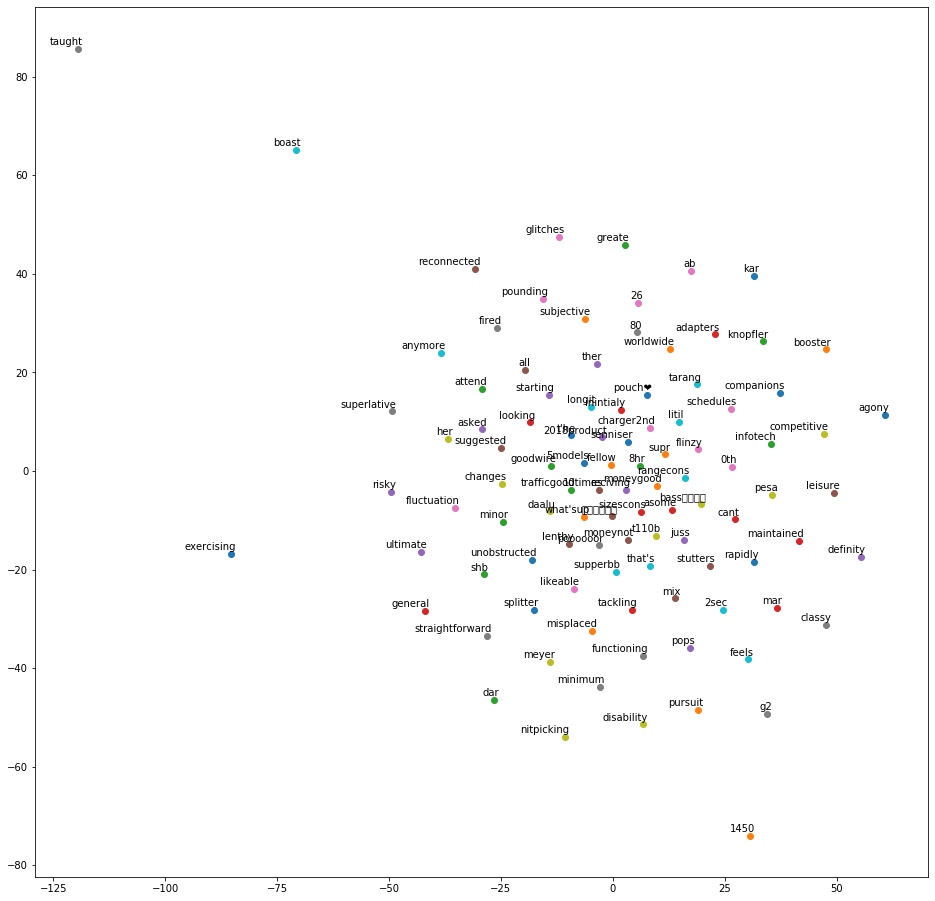

In [41]:
#https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
labels = []
tokens = []
for word in subset_dict:
    tokens.append(subset_dict[word])
    labels.append(word)
tsne_model = TSNE(n_components=2)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
z = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    #z.append(value[2])
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In the reduced dimensionality embedding the x axis represents the negative connotations of the words at the two extremes of the axis. While the words that have general good connotations to people are clustered near the origin. As for the y axis, it represents adjectives that are perceived to cause issues at distances further away from the origin. While near the origin for the y axis, adjectives with good connotations are clustered extremely close to one another.